In [1]:

import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from einops import rearrange
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch import nn
from typing import Any
import glob
import re
from datetime import datetime
import random
from collections import defaultdict
import torch.nn.functional as torch_func
from torchvision.transforms.functional import rotate, affine, resize, center_crop

random.seed(42)

In [2]:
from models.allcnn2d import AllCNN2D
from drawing.interactive import draw_image

# Global

In [3]:
DEVICE: str = "cuda" if torch.cuda.is_available() else "cpu"

# Paths

In [4]:
file_path: str = os.path.abspath(".")
root_path: str = os.path.join(file_path, os.pardir, os.pardir)
checkpoint_path: str = os.path.join(
    root_path, 
    "checkpoints", 
    "Krud_epoch29_trainacc0.93466_valacc0.97159_Tloss0.013132_Vloss0.0056677_lr0.0007224.pkl"
)


# Load Model

In [5]:
label_map: list[str] = ['(', ')', '+', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'λ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '×', '÷']

model: AllCNN2D = AllCNN2D(
    **{
        "conv_features": (1, 16, 32, 32, 32, 32),
        "fully_connected_features": (64, 44),
        "expected_input_size": (64, 64),
        "device": "cuda",
        "conv_dropout": 0.0,
        "verbose": True,
        "name_prefix": "KrudEval",
        "checkpoint_path": checkpoint_path
    }

).eval()

c:\Users\Leon\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Loaded: encoder_conv_blocks.0.0.weight
Loaded: encoder_conv_blocks.0.0.bias
Loaded: encoder_conv_blocks.0.2.weight
Loaded: encoder_conv_blocks.0.2.bias
Loaded: encoder_conv_blocks.0.2.running_mean
Loaded: encoder_conv_blocks.0.2.running_var
Loaded: encoder_conv_blocks.0.2.num_batches_tracked
Loaded: encoder_conv_blocks.0.4.weight
Loaded: encoder_conv_blocks.0.4.bias
Loaded: encoder_conv_blocks.0.6.weight
Loaded: encoder_conv_blocks.0.6.bias
Loaded: encoder_conv_blocks.0.6.running_mean
Loaded: encoder_conv_blocks.0.6.running_var
Loaded: encoder_conv_blocks.0.6.num_batches_tracked
Loaded: encoder_conv_blocks.1.0.weight
Loaded: encoder_conv_blocks.1.0.bias
Loaded: encoder_conv_blocks.1.2.weight
Loaded: encoder_conv_blocks.1.2.bias
Loaded: encoder_conv_blocks.1.2.running_mean
Loaded: encoder_conv_blocks.1.2.running_var
Loaded: encoder_conv_blocks.1.2.num_batches_tracked
Loaded: encoder_conv_blocks.1.4.weight
Loaded: encoder_conv_blocks.1.4.bias
Loaded: encoder_conv_blocks.1.6.weight
Loaded

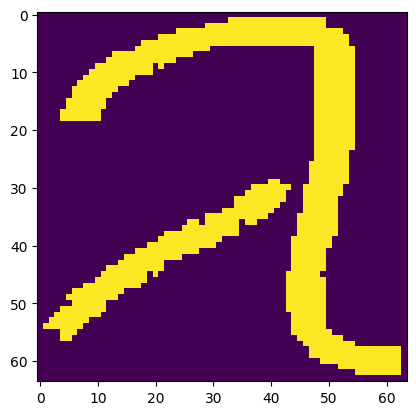

15
λ


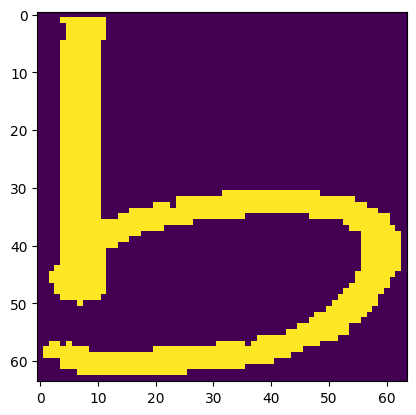

17
b


KeyboardInterrupt: 

In [31]:

def resize_to_preprocess(im: torch.Tensor, pad=1) -> torch.Tensor:
    
    mask = im > 0.5  # Assuming foreground is black (0) and background is white (1)
    coords = torch.nonzero(mask)
    if coords.shape[0] > 0:
        min_x, min_y = coords.min(dim=0)[0].tolist()[2:]
        max_x, max_y = coords.max(dim=0)[0].tolist()[2:]
        
        im = im[:, :, min_x:max_x + 1, min_y:max_y + 1]
    else:
        # If no black pixels are found, return the original image
        pass

    
    im: torch.Tensor = resize(im, (64-2*pad, 64-2*pad), antialias=True)
    
    im = (im > 0.5).type(torch.uint8).type(torch.float32)

    im = torch_func.pad(
        im,
        (pad, pad, pad, pad),
        mode='constant',
        value=0.0
    )
    return im

stop_drawing = False

while not stop_drawing:

    # Example usage:
    drawn_image_np: np.ndarray | None = 1.0-draw_image()
    
    
    if drawn_image_np is None:
        print("No image drawn.")
        stop_drawing = True
        continue
    
    drawn_image_np = drawn_image_np.astype(np.uint8).astype(np.float32)
    
    drawn_image_tensor: torch.Tensor = torch.tensor(
        drawn_image_np, 
        device=DEVICE
    )    
    drawn_image_tensor = resize_to_preprocess(drawn_image_tensor.unsqueeze(0).unsqueeze(0))
    
    plt.imshow(drawn_image_tensor[0, 0, :, :].cpu())
    plt.show()
    
    
    logits: torch.Tensor = model.forward(drawn_image_tensor).detach().cpu()
    pred: int = torch.argmax(logits, dim=1).squeeze().item()
    
    print(pred)  # Should print (64, 64), a 64x64 numpy array
    print(label_map[pred])

        
        
    